## Basis Functions for Nonlinear Regression
### David S. Rosenberg

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In this notebook we're going to investigate how to use linear regression to approximate and estimate complicated functions.  For example, suppose we want to fit the following function on the interval $[0,1]$:

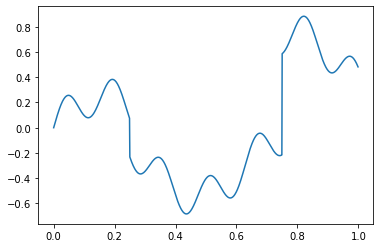

In [2]:
def y(x):
    ret = .15*np.sin(40*x) 
    ret = ret + .25*np.sin(10*x)
    step_fn1 = np.zeros(len(x))
    step_fn1[x >= .25] = 1
    step_fn2 = np.zeros(len(x))
    step_fn2[x >= .75] = 1
    ret = ret - 0.3*step_fn1 + 0.8 *step_fn2 
    return ret

x = np.arange(0.0, 1.0, 0.001)
plt.plot(x, y(x))
plt.show()


Here the input space, shown on the x-axis, is very simple -- it's just the interval $[0,1]$.  The output space is reals ($\mathcal{R}$), and a graph of the function $\{(x,y(x)) \mid x \in [0,1]\}$ is shown above.  Clearly a linear function of the input will not give a good approximation to the function.  There are many ways to construct nonlinear functions of the input.  Some popular approaches in machine learning are regression trees, neural networks, and local regression (e.g. LOESS).  However, our approach here will be to map the input space $[0,1]$ into a "feature space" $\mathcal{R}^d$, and then run standard linear regression in the feature space. 

Feature extraction, or "featurization", maps an input from some input space $\mathcal{X}$ to a vector in $\mathcal{R}^d$.  Here our input space is $\mathcal{X}=[0,1]$, so we could write our feature mapping as a function $\Phi:[0,1]\to\mathcal{R}^d$. The vector $\Phi(x)$ is called a feature vector, and each entry of the vector is called a feature.  Our feature mapping is typically defined in terms of a set of functions, each computing a single entry of the feature vector.  For example, let's define a feature function $\phi_1(x)=1(x\ge0.25)$.  The $1(\cdot)$ denotes an indicator function, which is 1 if the expression in the parenthesis is true, and 0 otherwise.  So $\phi_1(x)$ is $1$ if $x\ge0.25$ and $0$ otherwise.  This function produces a "feature" of x.  Let's define two more features: $\phi_2(x)=1(x\ge0.5)$ and $\phi_3(x)=1(x\ge0.75)$. Now we can define a feature mapping into $\mathcal{R}^3$ as:
$$ \Phi(x) = ( \phi_1(x), \phi_2(x), \phi_3(x) ).$$

Let's code up these feature functions explicitly and plot them as functions of $x$:


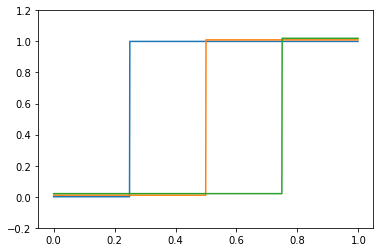

In [3]:
def step_fn_generator(step_loc=0):
    def f(x):
        ret = np.zeros(len(x))
        ret[x >= step_loc] = 1
        return ret
    return f

phi_1 = step_fn_generator(0.25)
phi_2 = step_fn_generator(0.50)
phi_3 = step_fn_generator(0.75)

x = np.arange(0.0, 1.0, 0.001)

plt.plot(x, phi_1(x)) 
plt.plot(x, phi_2(x)+.01) #adding perturbation .01 so we the plots don't overlap
plt.plot(x, phi_3(x)+.02) 
plt.ylim([-.2,1.2])
plt.show()

In the plot above we see graphs of the 3 feature functions we defined. We note that feature functions in this context are often called "basis functions" (See Hastie et al's ESL Section 5.1).  You should convince yourself that the feature mapping $\Phi(x)$ only takes on 4 different values as $x$ ranges over the input space $[0,1]$.  For example, the input $0.4$ gets mapped to the vector $(1,0,0)$ under $\Phi$, since $\Phi(0.4) =( \phi_1(0.4), \phi_2(0.4),\phi_3(0.4) )= (1,0,0)$.  

On one hand, the featurization loses a lot of information that was originally contained in the input $x$. (e.g. every input value in the interval $(.25,.5)$ gets mapped to the same feature vector.  On the other hand, affine combinations (i.e. linear combinations plus a constant) of our feature functions can now produce highly nonlinear functions of $x$, as we see in the plots below:

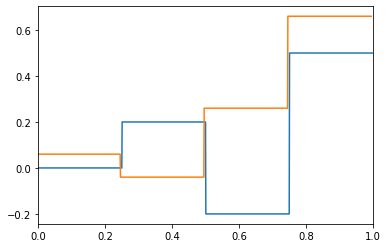

In [5]:
def linear_comb_generator(fns, coefs):
    def f(x):
        return sum(fns[i](x) * coefs[i] for i in range(len(fns)))
    return f

Phi = [phi_1, phi_2, phi_3]
f_1 = linear_comb_generator(Phi, [.2, -.4, .7])
f_2 = linear_comb_generator(Phi, [-.1, .3, .4]) 
plt.plot(x, f_1(x)) 
plt.plot(x-.005, f_2(x)+ .06)  #-0.005 just so easier to view the functions
plt.xlim([0,1])
plt.show()

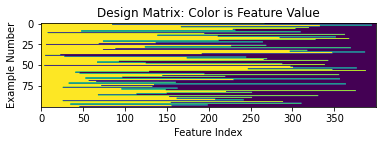

Hoping this is very close to 0:4.694017605044971e-11
    param_l2reg  mean_test_score  mean_train_score
0      0.000001         0.172579          0.006752
1      0.000010         0.172464          0.006752
2      0.000100         0.171345          0.006774
3      0.001000         0.162705          0.008285
4      0.010000         0.141887          0.032767
5      0.100000         0.144566          0.094953
6      1.000000         0.171068          0.197694
7      1.300000         0.179521          0.216591
8      1.600000         0.187993          0.233450
9      1.900000         0.196361          0.248803
10     2.200000         0.204553          0.262958
11     2.500000         0.212530          0.276116
12     2.800000         0.220271          0.288422


<ipython-input-7-31fc26d2d9df>:183: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-7-31fc26d2d9df>:203: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-7-31fc26d2d9df>:206: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


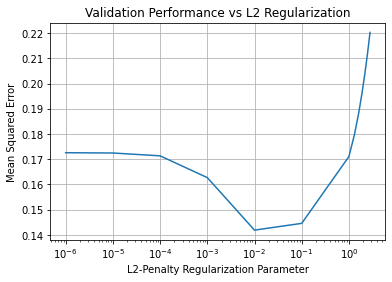

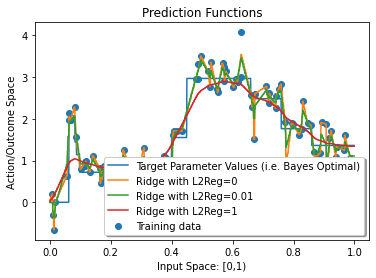

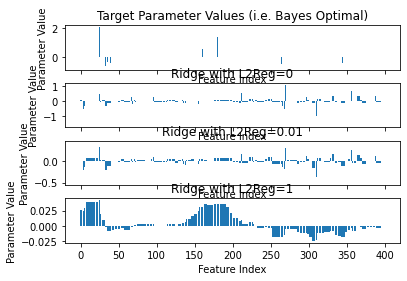

In [7]:
"""
Ridge regression using scipy's minimize function and demonstrating the use of
sklearn's framework.

Author: David S. Rosenberg <david.davidr@gmail.com>
License: Creative Commons Attribution 4.0 International License
"""
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd

from setup_problem import load_problem

class RidgeRegression(BaseEstimator, RegressorMixin):
    """ ridge regression"""

    def __init__(self, l2reg=1):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg = l2reg

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        def ridge_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) / n
            l2_norm_squared = np.sum(w**2)
            objective = empirical_risk + self.l2reg * l2_norm_squared
            return objective
        self.ridge_obj_ = ridge_obj

        w_0 = np.zeros(num_ftrs)
        self.w_ = minimize(ridge_obj, w_0).x
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)



def compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1):
    # First run sklearn ridge regression and extract the coefficients
    from sklearn.linear_model import Ridge
    # Fit with sklearn -- need to multiply l2_reg by sample size, since their
    # objective function has the total square loss, rather than average square
    # loss.
    n = X_train.shape[0]
    sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
    sklearn_ridge.fit(X_train, y_train)
    sklearn_ridge_coefs = sklearn_ridge.coef_

    # Now run our ridge regression and compare the coefficients to sklearn's
    ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
    ridge_regression_estimator.fit(X_train, y_train)
    our_coefs = ridge_regression_estimator.w_

    print("Hoping this is very close to 0:{}".format(np.sum((our_coefs - sklearn_ridge_coefs)**2)))

def do_grid_search_ridge(X_train, y_train, X_val, y_val):
    # Now let's use sklearn to help us do hyperparameter tuning
    # GridSearchCv.fit by default splits the data into training and
    # validation itself; we want to use our own splits, so we need to stack our
    # training and validation sets together, and supply an index
    # (validation_fold) to specify which entries are train and which are
    # validation.
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

    # Now we set up and do the grid search over l2reg. The np.concatenate
    # command illustrates my search for the best hyperparameter. In each line,
    # I'm zooming in to a particular hyperparameter range that showed promise
    # in the previous grid. This approach works reasonably well when
    # performance is convex as a function of the hyperparameter, which it seems
    # to be here.
    param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
                                           np.arange(1,3,.3)
                                             ))) }]

    ridge_regression_estimator = RidgeRegression()
    grid = GridSearchCV(ridge_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)

    df = pd.DataFrame(grid.cv_results_)
    # Flip sign of score back, because GridSearchCV likes to maximize,
    # so it flips the sign of the score if "greater_is_better=FALSE"
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l2reg"])
    return grid, df_toshow

def compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, sharex=True)
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)

    fig.subplots_adjust(hspace=0.3)
    return fig

def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "preds" key. The value corresponding to the "preds" key is an array of
    # predictions corresponding to the input vector x. x_train and y_train are
    # the input and output values for the training data
    fig, ax = plt.subplots()
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, label='Training data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig

def main():

if __name__ == '__main__':
    main()


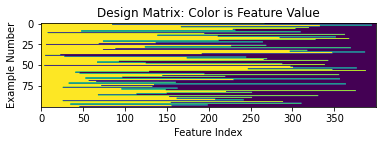

(100, 400)

In [9]:
lasso_data_fname = "lasso_data.pickle"
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

# Generate features
X_train = featurize(x_train)
X_val = featurize(x_val)

#Visualize training data
fig, ax = plt.subplots()
ax.imshow(X_train)
ax.set_title("Design Matrix: Color is Feature Value")
ax.set_xlabel("Feature Index")
ax.set_ylabel("Example Number")
plt.show(block=False)
X_train.shape